**Task 1: Clustering**

In class, you have been introduced to the unsupervised learning and the K-means
algorithm ang GMM. Our goal is to categorize the two-dimensional dataset cluster.dat
into several clusters.

**Method 1. K-means (20 points)**

Implement K-means method on the cluster.dat. You should try different numbers of
clusters.

In [1]:
%pylab inline
# following is alternative import
# import numpy as np
# import matplotlib as plt

cluster_dat = np.loadtxt("cluster.dat")
print(cluster_dat.shape)
print(cluster_dat)

Populating the interactive namespace from numpy and matplotlib
(1000, 2)
[[-6.3670924  -0.35240556]
 [-0.08979119  1.5166165 ]
 [ 0.22860334 -3.4007959 ]
 ...
 [-2.5545522  -4.7181746 ]
 [-0.20151563  2.9328022 ]
 [-0.36624411 -3.0872141 ]]


In [2]:
import random


def kmeans_2d_sse(data, labels, centroids):
    sse = 0
    for i in range(0, int(labels.max()) + 1):
        if not np.isnan(centroids[i]).any():
            sse += np.sqrt((np.power(data[labels == i] - centroids[i],
                                     2)).sum(axis=1)).sum()
    return sse


def kmeans_2d_predict_sse(data, centroids):
    labels = np.zeros(data.shape[0])
    for i, point in enumerate(data):
        labels[i] = np.argmin(
            np.sqrt((np.power(point - centroids, 2)).sum(axis=1)))
    return kmeans_2d_sse(data, labels, centroids)


def init_centroid_2d(data, k):
    min_x = np.min(data[:, 0])
    max_x = np.max(data[:, 0])
    min_y = np.min(data[:, 1])
    max_y = np.max(data[:, 1])

    centroid_x = random.uniform(min_x, max_x)
    centroid_y = random.uniform(min_y, max_y)
    centroids = np.array([centroid_x, centroid_y])
    for i in range(1, k):
        centroid_x = random.uniform(min_x, max_x)
        centroid_y = random.uniform(min_y, max_y)
        centroids = np.vstack([centroids, [centroid_x, centroid_y]])
    return centroids


def kmeans_2d(data, k):
    centroids = init_centroid_2d(data, k)

    labels = np.zeros(data.shape[0])
    for i, point in enumerate(data):
        labels[i] = np.argmin(
            np.sqrt((np.power(point - centroids, 2)).sum(axis=1)))
    new_centroids = centroids.copy()

    for i in range(0, k):
        new_centroids[i] = np.mean(data[labels == i], axis=0)

    while kmeans_2d_predict_sse(data, new_centroids) < kmeans_2d_sse(
            data, labels, centroids):
        if np.isnan(new_centroids).any():
            return kmeans_2d(data, k)  # try again
        centroids = new_centroids
        for i, point in enumerate(data):
            labels[i] = np.argmin(
                np.sqrt((np.power(point - centroids, 2)).sum(axis=1)))
        for i in range(0, k):
            new_centroids[i] = np.mean(data[labels == i], axis=0)

    labels = np.zeros(data.shape[0])
    for i, point in enumerate(data):
        labels[i] = np.argmin(
            np.sqrt((np.power(point - centroids, 2)).sum(axis=1)))

    return labels, new_centroids, kmeans_2d_sse(data, labels, new_centroids)

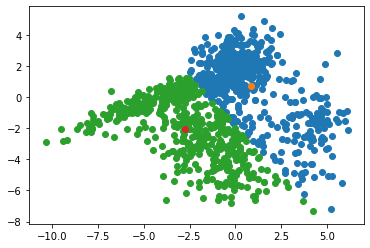

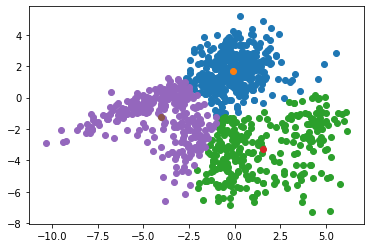

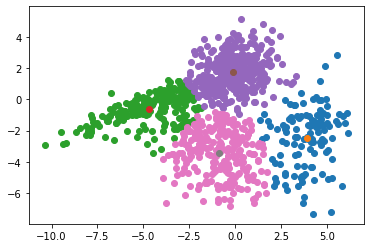

C:\Users\80596\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\80596\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


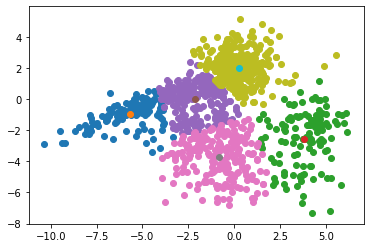

In [3]:
K = range(2, 6)

for k in K:
    labels, centroids, _ = kmeans_2d(cluster_dat, k)
    for i in range(0, k):
        plt.scatter(cluster_dat[labels == i][:, 0],
                    cluster_dat[labels == i][:, 1])
        plt.scatter(centroids[i, 0], centroids[i, 1])
    plt.show()

**Do something extra! (BONUS: 10 points)**

Split the dataset using 80-20 train-test ratio. Train your predictor using newlyimplemented K_means function. Iterate over k, for each report the training and
testing loss. Plot training and testing loss versus k. Plot the samples for three choices
of k. Pick k which reveals the structure of the data. Comment the results.

C:\Users\80596\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\80596\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


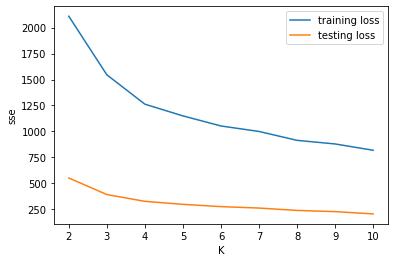

In [4]:
from sklearn import model_selection

K = range(2, 11)

cluster_train, cluster_test = model_selection.train_test_split(cluster_dat,
                                                               test_size=0.2)

sse_train = np.zeros(K.stop - 2)
sse_test = np.zeros(K.stop - 2)

for k in K:
    labels, centroids, sse_train[k - 2] = kmeans_2d(cluster_train, k)
    sse_test[k - 2] = kmeans_2d_predict_sse(cluster_test, centroids)
plt.plot(K, sse_train, label='training loss')
plt.plot(K, sse_test, label='testing loss')
plt.xticks(K)
plt.xlabel("K")
plt.ylabel("sse")
plt.legend()
plt.show()

**Comment**

k不同的聚类在上面，其实还是很难看出这组数据的结构的，因为数据本身分布密集程度就很高，把它分成1类都是合理的，但如果一定要选的话，k=5时分成的5组直观上更好，同时训练和测试sse都比较小，更高的k对sse的下降效果也变更加弱

**Method 2. Gaussian Mixture Model (30 points)**

Implement EM fitting of a mixture of gaussians on the cluster.dat. You should try
different numbers of mixtures, as well as tied vs. separate covariance matrices for
each gaussian.

In [5]:
from scipy.stats import multivariate_normal


def E_step(data, means, covs, weights):
    n_data = data.shape[0]
    n_clusters = means.shape[0]
    responsibilities = np.zeros([n_data, n_clusters])
    for c in range(n_clusters):
        responsibilities[:, c] = multivariate_normal.pdf(
            data, means[c], covs[c])
    responsibilities = weights * responsibilities
    responsibilities /= responsibilities.sum(axis=1)[:, np.newaxis]
    return responsibilities


def M_step(data, responsibilities, means, covs):
    n_data, n_clusters = responsibilities.shape
    weights = responsibilities.sum(axis=0)
    for c in range(n_clusters):
        resp = responsibilities[:, c][:, np.newaxis]
        means[c] = (resp * data).sum(axis=0) / resp.sum()
        covs[c] = ((data - means[c]).T).dot(
            (data - means[c]) * resp) / weights[c]
    weights /= weights.sum()
    return means, covs, weights


def Gaussian_Mixture(data, centroids, n_iterations=99):
    k = centroids.shape[0]
    means = centroids
    weights = np.ones(k) / k
    weights[0] += 1
    covs = np.array([np.cov(data.T)] * k)
    weights /= weights.sum()

    for i in range(n_iterations):
        responsibilities = E_step(data, means, covs, weights)
        means, covs, weights = M_step(data, responsibilities, means, covs)
        labels = responsibilities.argmax(axis=1)
    return labels

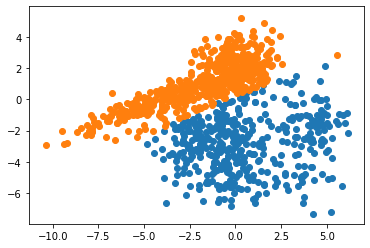

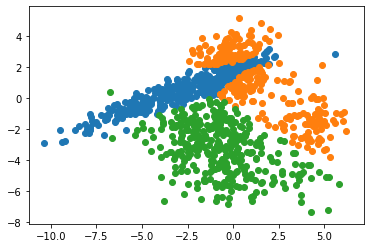

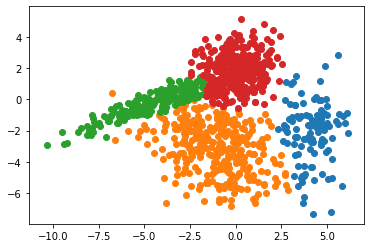

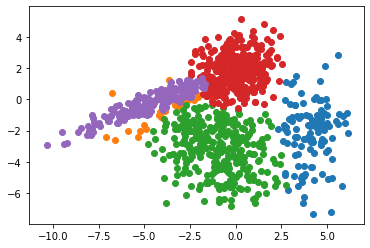

In [6]:
K = range(2, 6)

for k in K:
    labels = Gaussian_Mixture(cluster_dat,
                              init_centroid_2d(cluster_dat, k))
    for i in range(0, k):
        plt.scatter(cluster_dat[labels == i][:, 0],
                    cluster_dat[labels == i][:, 1])
    plt.show()

**Do something extra! (BONUS: 10 points)**

Split the dataset using 80-20 train-test ratio. Plot likelihood on training and testing vs
iteration for different numbers of mixtures.